In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
np.random.seed(203)
from tqdm import tqdm
import datetime
from collections import Counter
import re
import matplotlib.axes as ax

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

import lightgbm as lgb

/Users/s0c02nj/anaconda2/envs/bert/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
train_data = pd.read_csv('/Users/s0c02nj/Desktop/LTFS/train_aox2Jxw/train.csv')
test_data =  pd.read_csv('/Users/s0c02nj/Desktop/LTFS/test_bqCt9Pv.csv')
sub_data = pd.read_csv('/Users/s0c02nj/Desktop/LTFS/sample_submission_24jSKY6.csv')

In [3]:
x_train = train_data.drop('loan_default',axis=1)
y_def = train_data['loan_default']

In [4]:
x_train = x_train.drop('UniqueID',axis=1)
x_test =  test_data.drop('UniqueID',axis=1)

In [5]:
x_comb = pd.concat([x_train,x_test],sort=False)

In [6]:
x_comb = x_comb.replace(np.nan, 'unknown', regex=True)

In [7]:
from datetime import timedelta, date
col = 'date'
x_comb['Date.of.Birth'] = pd.to_datetime(x_comb['Date.of.Birth'])
future = x_comb['Date.of.Birth'] > date(year=2050,month=1,day=1)
x_comb.loc[future, 'Date.of.Birth'] -= timedelta(days=365.25*100)

/Users/s0c02nj/anaconda2/envs/bert/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  after removing the cwd from sys.path.


In [8]:
from datetime import timedelta, date
col = 'date'
x_comb['DisbursalDate'] = pd.to_datetime(x_comb['DisbursalDate'])
future = x_comb['DisbursalDate'] > date(year=2050,month=1,day=1)
x_comb.loc[future, 'DisbursalDate'] -= timedelta(days=365.25*100)

/Users/s0c02nj/anaconda2/envs/bert/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  after removing the cwd from sys.path.


In [9]:
x_comb['age'] = 2018-x_comb['Date.of.Birth'].dt.year

In [10]:
x_comb['disbursion_wk'] =   x_comb['DisbursalDate'].dt.week
x_comb['disbursion_mnth'] = x_comb['DisbursalDate'].dt.month
x_comb['disbursion_day'] =  x_comb['DisbursalDate'].dt.day

In [11]:
x_comb['avg_acct_age_yr'] =  x_comb['AVERAGE.ACCT.AGE'].apply(lambda x:re.findall(r'\d+', x)[0]).astype(int)
x_comb['avg_acct_age_mon'] = x_comb['AVERAGE.ACCT.AGE'].apply(lambda x:re.findall(r'\d+', x)[1]).astype(int)

x_comb['cred_his_yr'] =  x_comb['CREDIT.HISTORY.LENGTH'].apply(lambda x:re.findall(r'\d+', x)[0]).astype(int)
x_comb['cred_his_mon'] = x_comb['CREDIT.HISTORY.LENGTH'].apply(lambda x:re.findall(r'\d+', x)[1]).astype(int)

In [12]:
x_comb = x_comb.drop(['Date.of.Birth', 'DisbursalDate','AVERAGE.ACCT.AGE','CREDIT.HISTORY.LENGTH'], axis=1)

In [13]:
#x_comb['DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS_cat'] = x_comb['DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS']

In [14]:
com_count={}
for col in tqdm(list(x_comb.columns)):
    val = len(x_comb[col].unique())
    com_count[col]=val

100%|██████████| 43/43 [00:00<00:00, 154.65it/s]


In [15]:
total_cols = list(x_comb.columns)

In [16]:
cat_cols = ['branch_id','supplier_id','manufacturer_id','Current_pincode_ID','Employment.Type',
           'State_ID','Employee_code_ID','Aadhar_flag','PAN_flag','VoterID_flag','Driving_flag',
           'Passport_flag','PERFORM_CNS.SCORE.DESCRIPTION',
           'disbursion_wk','disbursion_mnth','disbursion_day','PRI.NO.OF.ACCTS']

In [17]:
cont_cols = list(set(total_cols)-set(cat_cols))

In [18]:
for i,col in tqdm(enumerate(cont_cols)):
    counter = Counter(x_comb[col])
    x_comb[str(col)+'count'] = x_comb[col].apply(lambda x:counter[x])

26it [00:08,  2.85it/s]


In [19]:
cont_cols_new = list(set(list(x_comb.columns))-set(cat_cols))

In [20]:
for col in tqdm(cat_cols):
    le = LabelEncoder()
    x_comb[col] = le.fit_transform(x_comb[col])

100%|██████████| 17/17 [00:00<00:00, 19.61it/s]


/Users/s0c02nj/anaconda2/envs/bert/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(0, 100000)

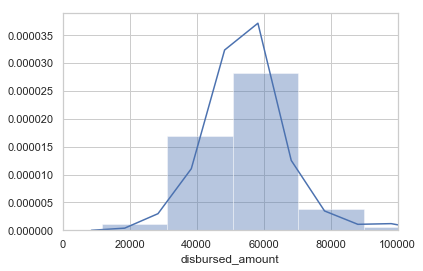

In [21]:
sns.distplot(x_comb['disbursed_amount'])
plt.xlim(0,100000)

In [22]:
q = x_comb['disbursed_amount'].quantile(0.99)

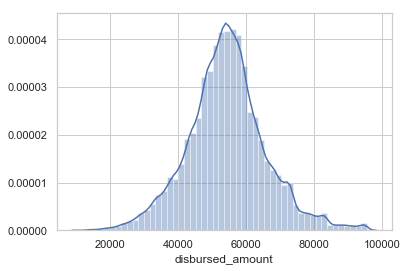

In [23]:
q = x_comb['disbursed_amount'].quantile(0.99)
a =x_comb[x_comb['disbursed_amount'] < q]['disbursed_amount']
sns.distplot(a)

In [24]:
#x_comb['disbursed_amount'].shape

(0, 200000)

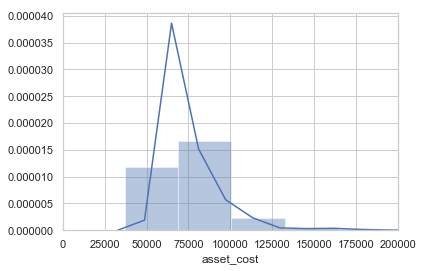

In [25]:
sns.distplot(x_comb['asset_cost'])
plt.xlim(0,200000)

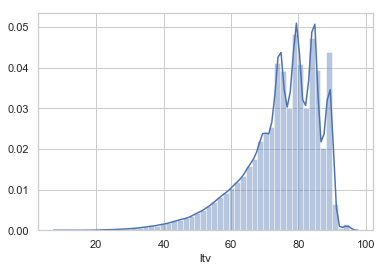

In [26]:
sns.distplot(x_comb['ltv'])
#plt.xlim(0,200000)

In [ ]:
sns.distplot(x_comb['PERFORM_CNS.SCORE'])
#plt.xlim(0,200000)

In [ ]:
sns.distplot(x_comb['DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS'])
plt.xlim(0,2.5)

In [ ]:
sns.distplot(x_comb['disbursed_amount'])

In [ ]:
sns.distplot(x_comb['SEC.ACTIVE.ACCTS'])
plt.xlim(-1,10)

In [ ]:
var=[]
for cols in cont_cols:
    var.append((cols,x_comb[cols].var()))

In [ ]:
x_cont = x_comb[cont_cols]

In [ ]:
# Q1 = x_cont.quantile(0.25)
# Q3 = x_cont.quantile(0.75)
# IQR = Q3 - Q1
# print(IQR)

In [ ]:
#print(x_cont < (Q1 - 1.5 * IQR)) |(x_cont > (Q3 + 1.5 * IQR))

In [ ]:
x_cont.columns

In [ ]:
#means = df.groupby('x_0')['y'].mean()